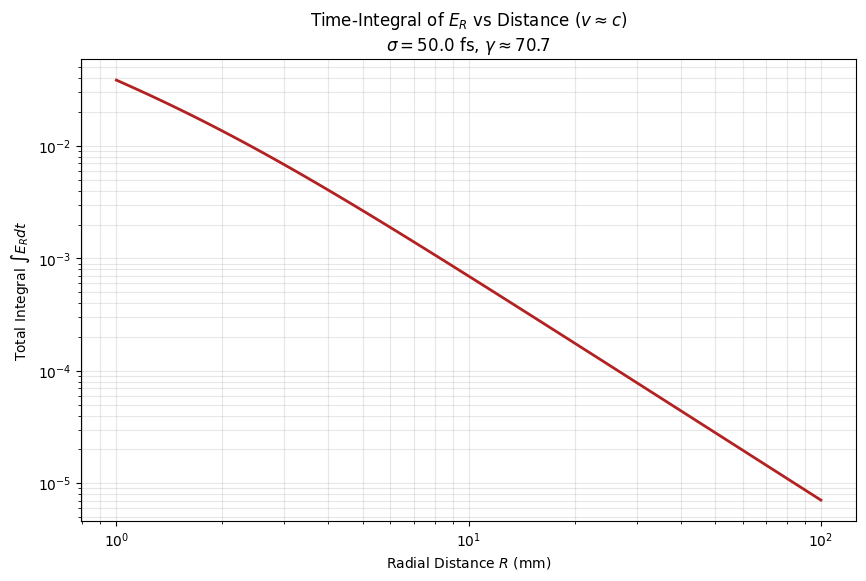

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# 1. Physical Constants
c = 299792458       # Speed of light (m/s)
v_factor = 0.9999   # Velocity as fraction of c (e.g., 0.9999c)
v = v_factor * c
gamma = 1 / np.sqrt(1 - (v/c)**2)

# 2. Pulse Parameters
sigma_fs = 50.0            # Pulse width in femtoseconds
sigma = sigma_fs * 1e-15   # Convert to seconds
Q_total = 1e-9             # Total charge in Coulombs (e.g., 1 nC)

# 3. Scaled Integrand
# To avoid numerical issues with 10^-15, we substitute t = sigma * tau.
# This makes the Gaussian component exp(-0.5 * tau^2).
def scaled_integrand(tau, R, gamma, v, sigma, Q):
    # Gaussian current part (normalized)
    gauss = (Q / np.sqrt(2 * np.pi)) * np.exp(-0.5 * tau**2)
    
    # Geometric part E_R
    # Original denominator: (R^2 + (gamma*v*t)^2)^1.5
    # Becomes: (R^2 + (gamma*v*sigma*tau)^2)^1.5
    numerator = gamma * R
    denominator = (R**2 + (gamma * v * sigma * tau)**2)**1.5
    
    return gauss * (numerator / denominator)

# 4. Computation
def compute_exposure(R_range):
    results = []
    for R in R_range:
        # We integrate over tau from -infinity to +infinity
        # quad is robust, and the scaling ensures it sees the pulse peak
        val, _ = quad(scaled_integrand, -np.inf, np.inf, args=(R, gamma, v, sigma, Q_total))
        results.append(val)
    return np.array(results)

# 5. Define R range (from 1 mm to 100 mm)
R_axis = np.geomspace(1e-3, 1e-1, 100) 
integral_values = compute_exposure(R_axis)

# 6. Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(R_axis * 1000, integral_values, color='firebrick', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.title(f'Time-Integral of $E_R$ vs Distance ($v \\approx c$)\n'
          f'$\\sigma = {sigma_fs}$ fs, $\\gamma \\approx {gamma:.1f}$')
plt.xlabel('Radial Distance $R$ (mm)')
plt.ylabel(r'Total Integral $\int E_R dt$')
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.show()

In [3]:
import numpy as np

def laser_heater_current_profile(t, total_electrons=6e9, primary_length_um=100.0, 
                               spike_peak_A=10000.0, spike_fwhm_fs=1.0, spike_delay_fs=0.0):
    """
    Computes the current profile I(t) in Amperes over a provided time grid t.
    
    t: array of time points in femtoseconds
    total_electrons: total number of electrons in the combined bunch
    primary_length_um: spatial sigma of the main bunch in micrometers
    spike_peak_A: peak current of the secondary spike in Amperes
    spike_fwhm_fs: Full Width Half Max of the spike in femtoseconds
    spike_delay_fs: delay of the spike peak from t=0 in femtoseconds
    """
    # --- Physical Constants ---
    c = 299792458.0           # m/s
    e_charge = 1.602176634e-19 # Coulombs
    Q_target = total_electrons * e_charge
    
    # --- Primary Pulse Parameters ---
    # Convert spatial length (100um) to temporal sigma in fs
    sigma_t1 = (primary_length_um * 1e-6) / c * 1e15  # in fs
    
    # --- Secondary Spike Parameters ---
    # Convert FWHM to sigma: sigma = FWHM / (2 * sqrt(2 * ln 2))
    sigma_t2 = (spike_fwhm_fs) / (2 * np.sqrt(2 * np.log(2)))
    
    # --- Charge Allocation ---
    # Area under a Gaussian: Area = Peak * sigma * sqrt(2 * pi)
    Q2 = spike_peak_A * sigma_t2 * np.sqrt(2 * np.pi) * 1e-15  # Convert fs to s for Coulombs
    Q1 = Q_target - Q2
    print ("Total Charge (C): {:.2e}, Primary Charge (C): {:.2e}, Secondary Charge (C): {:.2e}".format(Q_target, Q1, Q2))
    
    if Q1 < 0:
        raise ValueError("The spike peak and width exceed the total allocated charge. Allocated charge: {:.2e} C".format(Q2))
    
    # --- Calculate Current Profiles ---
    # Primary: I1(t)
    I1 = (Q1 / (sigma_t1 * np.sqrt(2 * np.pi))) * np.exp(-t**2 / (2 * sigma_t1**2)) * 1e15  # Convert to Amperes (fs to s)
    
    # Secondary: I2(t)
    I2 = spike_peak_A * np.exp(-(t - spike_delay_fs)**2 / (2 * sigma_t2**2))
    
    return I1 + I2

In [4]:
import numpy as np

def oscillatory_cumulative_integral(t, E, S):
    """
    Evaluates the cumulative integral of E(t) * exp(-i S(t)) dt.
    Returns an array M(t) of the same length as t.
    """
    # Initialize the output array with complex zeros
    M = np.zeros(len(t), dtype=complex)
    
    # Calculate intervals
    dt = np.diff(t)
    
    # Calculate instantaneous frequency omega = dS/dt for each interval
    # Using the difference in phase over the time step
    dS = np.diff(S)
    
    # Midpoint approximation for the envelope E
    E_mid = 0.5 * (E[:-1] + E[1:])
    
    # Analytic integration of exp(-i * S(t)) over the interval [t_n, t_{n+1}]
    # Assuming S(t) is linear between points: S(tau) = S_n + (dS/dt) * tau
    # Integral = E_mid * exp(-i*S_n) * [exp(-i*dS) - 1] / (-i * dS/dt)
    
    delta_M = np.zeros_like(dt, dtype=complex)
    
    # Numerical safety: check where dS is near zero to avoid division by zero
    mask = np.abs(dS) > 1e-15
    
    # For regions with significant phase change:
    # We use the identity: (exp(-i*S_next) - exp(-i*S_prev)) / (-i * omega)
    # where omega = dS/dt
    delta_M[mask] = (np.exp(-1j * S[1:][mask]) - np.exp(-1j * S[:-1][mask])) / (-1j * (dS[mask] / dt[mask]))
    
    # For regions where phase is nearly constant (Taylor expansion limit):
    delta_M[~mask] = np.exp(-1j * S[:-1][~mask]) * dt[~mask]
    
    # Multiply by the envelope and compute the running sum
    M[1:] = np.cumsum(E_mid * delta_M)
    
    return M

Plot saved as 'relativistic_phase_plot.png'


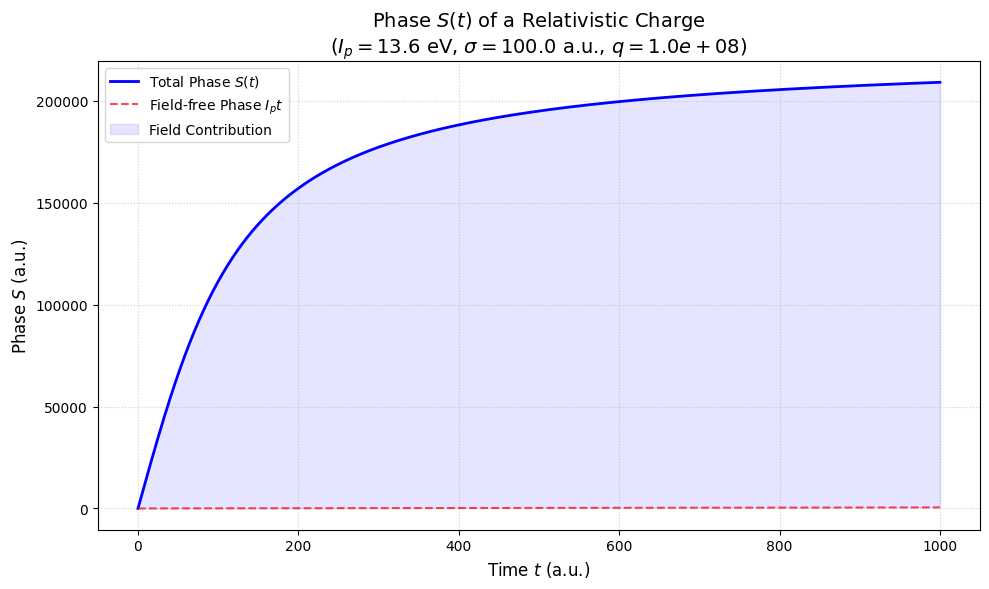

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def plot_relativistic_phase(Ip_eV, sigma_au, q=1.0e8, v_c=0.99):
    """
    Plots the phase S(t) in atomic units.
    
    Parameters:
    Ip_eV    : Ionization potential in electronvolts.
    sigma_au : Longitudinal spread of the charge in time (atomic units).
    q        : Charge magnitude (atomic units). Note: for a single electron q=1.
               Large q values represent a bunch, making the effect visible.
    v_c      : Velocity as a fraction of the speed of light.
    """
    # Constants in Atomic Units
    c_au = 137.036
    v = v_c * c_au
    Ip_au = Ip_eV / 27.21138  # Convert eV to Hartrees (a.u.)
    
    # Time array (from 0 to 10 * sigma to see the full pulse interaction)
    t = np.linspace(0, 10 * sigma_au, 1000)
    
    # Calculation of the Phase S(t)
    # Part 1: Integral of (1/2)|A|^2
    # Result of integral [0, t] of (q^2 / 2c^4) * 1/(t'^2 + sigma^2)
    S_A = (q**2 / (2 * c_au**4 * sigma_au)) * np.arctan(t / sigma_au)
    
    # Part 2: Ionization potential phase Ip * (t - t') with t'=0
    S_Ip = Ip_au * t
    
    S_total = S_A + S_Ip
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t, S_total, label=r'Total Phase $S(t)$', linewidth=2, color='blue')
    plt.plot(t, S_Ip, '--', label=r'Field-free Phase $I_p t$', color='red', alpha=0.7)
    
    # Highlighting the 'kick' from the vector potential
    plt.fill_between(t, S_Ip, S_total, color='blue', alpha=0.1, label='Field Contribution')
    
    plt.xlabel('Time $t$ (a.u.)', fontsize=12)
    plt.ylabel('Phase $S$ (a.u.)', fontsize=12)
    plt.title(f'Phase $S(t)$ of a Relativistic Charge\n'
              f'($I_p={Ip_eV}$ eV, $\sigma={sigma_au}$ a.u., $q={q:.1e}$)', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.savefig('relativistic_phase_plot.png')
    print("Plot saved as 'relativistic_phase_plot.png'")

# Example usage:
# Ip = 13.6 eV (Hydrogen), sigma = 100 a.u. (~2.4 fs)
plot_relativistic_phase(Ip_eV=13.6, sigma_au=100.0, q=1e8)

/tmp/ipykernel_140428/2749637539.py:30: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  S_t = cumtrapz(integrand, t, initial=0)


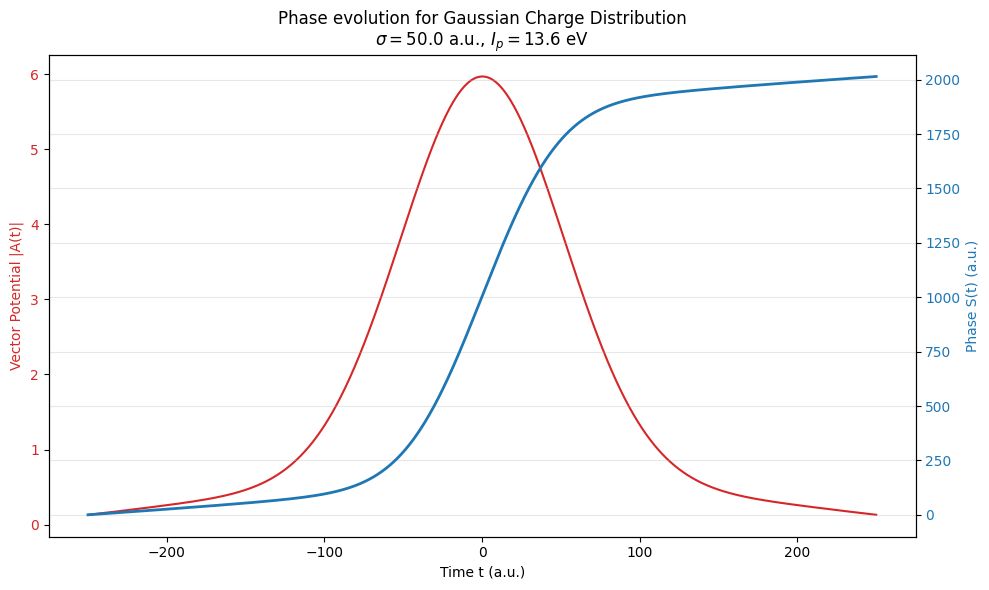

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

def plot_gaussian_charge_phase(Ip_eV, sigma_au, Q_total=1e8, v_c=0.99, b_gamma=10.0):
    # Constants (Atomic Units)
    c = 137.036
    v = v_c * c
    Ip = Ip_eV / 27.21138
    
    # Time grid
    t = np.linspace(-5*sigma_au, 5*sigma_au, 2000)
    dt = t[1] - t[0]
    
    # 1. Define Gaussian charge distribution q(t)
    q_t = Q_total * (1 / (np.sqrt(2 * np.pi) * sigma_au)) * np.exp(-t**2 / (2 * sigma_au**2))
    
    # 2. Define the point-charge response kernel (A_point)
    # Prefactor: mu_0 / 4pi = 1/c^2 in a.u.
    prefactor = v / (c**2)
    # To avoid singularity at t=0 if b_gamma is 0, we use b_gamma
    A_kernel = prefactor / np.sqrt((v * t)**2 + b_gamma**2)
    
    # 3. Convolve q(t) with A_kernel to get A_total(t)
    # We use 'same' to keep the time axis aligned
    A_total = np.convolve(q_t, A_kernel, mode='same') * dt
    
    # 4. Calculate Phase S(t) = Integral of (1/2 |A|^2 + Ip)
    integrand = 0.5 * (A_total**2) + Ip
    S_t = cumtrapz(integrand, t, initial=0)
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel('Time t (a.u.)')
    ax1.set_ylabel('Vector Potential |A(t)|', color=color)
    ax1.plot(t, A_total, color=color, label='Resulting |A(t)|')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Phase S(t) (a.u.)', color=color)
    ax2.plot(t, S_t, color=color, linewidth=2, label='Phase S(t)')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(f'Phase evolution for Gaussian Charge Distribution\n$\sigma={sigma_au}$ a.u., $I_p={Ip_eV}$ eV')
    fig.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

# Run with example parameters
plot_gaussian_charge_phase(Ip_eV=13.6, sigma_au=50.0, Q_total=1e6)

/tmp/ipykernel_140428/2103380713.py:27: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  S_t = cumtrapz(integrand_S, t, initial=0)
/tmp/ipykernel_140428/2103380713.py:31: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  M_t = cumtrapz(complex_integrand, t, initial=0)


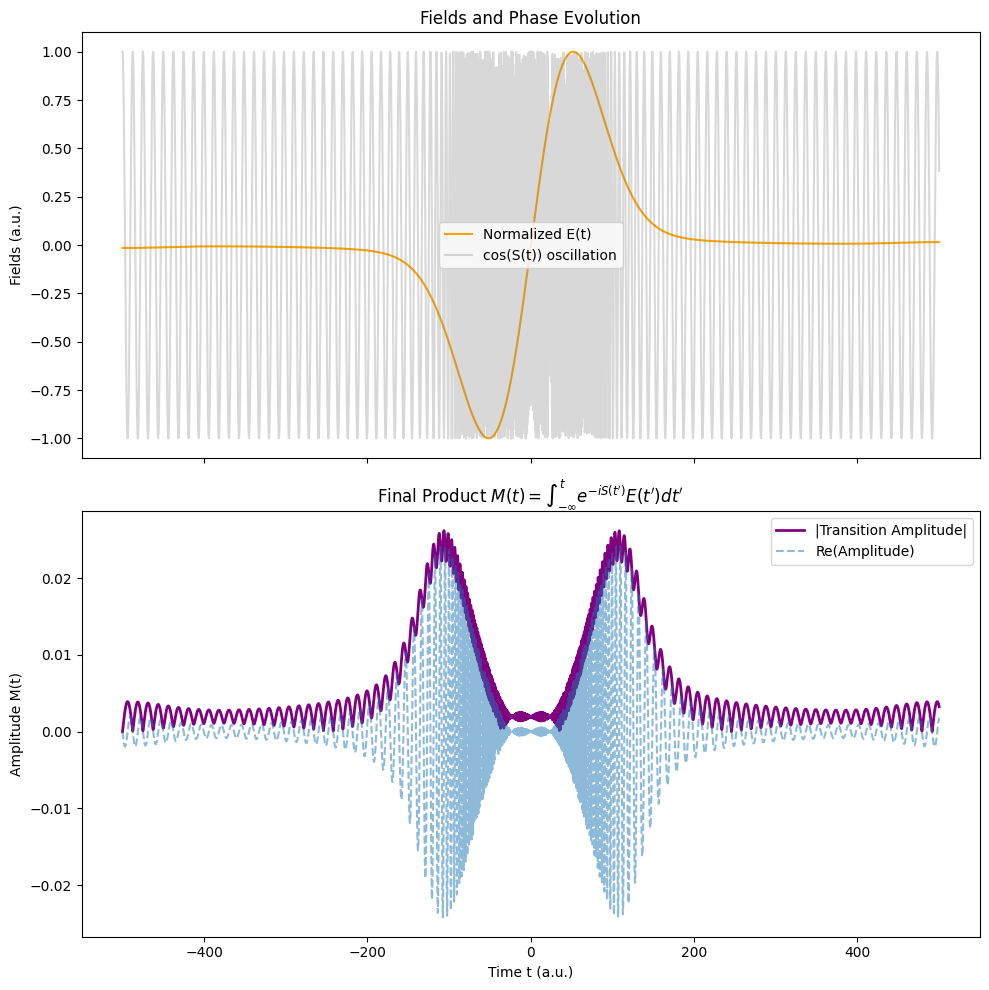

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

def compute_transition_amplitude(Ip_eV, sigma_au, Q_total=1e6, v_c=0.99, b_gamma=10.0):
    # 1. Setup Constants (Atomic Units)
    c_au = 137.036
    v = v_c * c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently wide to cover the Gaussian and field decay)
    t = np.linspace(-10 * sigma_au, 10 * sigma_au, 5000)
    dt = t[1] - t[0]
    
    # 2. Calculate A(t) via convolution
    ####################################### Define Gaussian charge distribution q(t) ####################
    q_t = Q_total * (1 / (np.sqrt(2 * np.pi) * sigma_au)) * np.exp(-t**2 / (2 * sigma_au**2))
    #####################################################################################################
    A_kernel = (v / c_au**2) / np.sqrt((v * t)**2 + b_gamma**2)
    A_total = np.convolve(q_t, A_kernel, mode='same') * dt
    
    # 3. Derive E(t) = -dA/dt
    E_t = -np.gradient(A_total, dt)
    
    # 4. Calculate Phase S(t)
    # S(t) = integral_{0 to t} [1/2 A^2 + Ip] dt'
    # We use a cumulative integral starting from the beginning of the grid
    integrand_S = 0.5 * (A_total**2) + Ip
    S_t = cumtrapz(integrand_S, t, initial=0)
    
    # 5. Compute the Product Integral: M(t) = integral e^{-iS(t')} E(t') dt'
    complex_integrand = np.exp(-1j * S_t) * E_t
    M_t = cumtrapz(complex_integrand, t, initial=0)
    
    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
    
    # Top Plot: Field and Phase
    ax1.plot(t, E_t / np.max(np.abs(E_t)), label="Normalized E(t)", color='orange')
    ax1.plot(t, np.cos(S_t), label="cos(S(t)) oscillation", alpha=0.3, color='gray')
    ax1.set_ylabel("Fields (a.u.)")
    ax1.set_title("Fields and Phase Evolution")
    ax1.legend()
    
    # Bottom Plot: The Resulting Product (Amplitude)
    ax2.plot(t, np.abs(M_t), label="|Transition Amplitude|", color='purple', linewidth=2)
    ax2.plot(t, M_t.real, label="Re(Amplitude)", alpha=0.5, linestyle='--')
    ax2.set_xlabel("Time t (a.u.)")
    ax2.set_ylabel("Amplitude M(t)")
    ax2.set_title(r"Final Product $M(t) = \int_{-\infty}^t e^{-iS(t')} E(t') dt'$")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return t, M_t

# Run the computation
t_axis, amplitude = compute_transition_amplitude(Ip_eV=13.6, sigma_au=50.0)

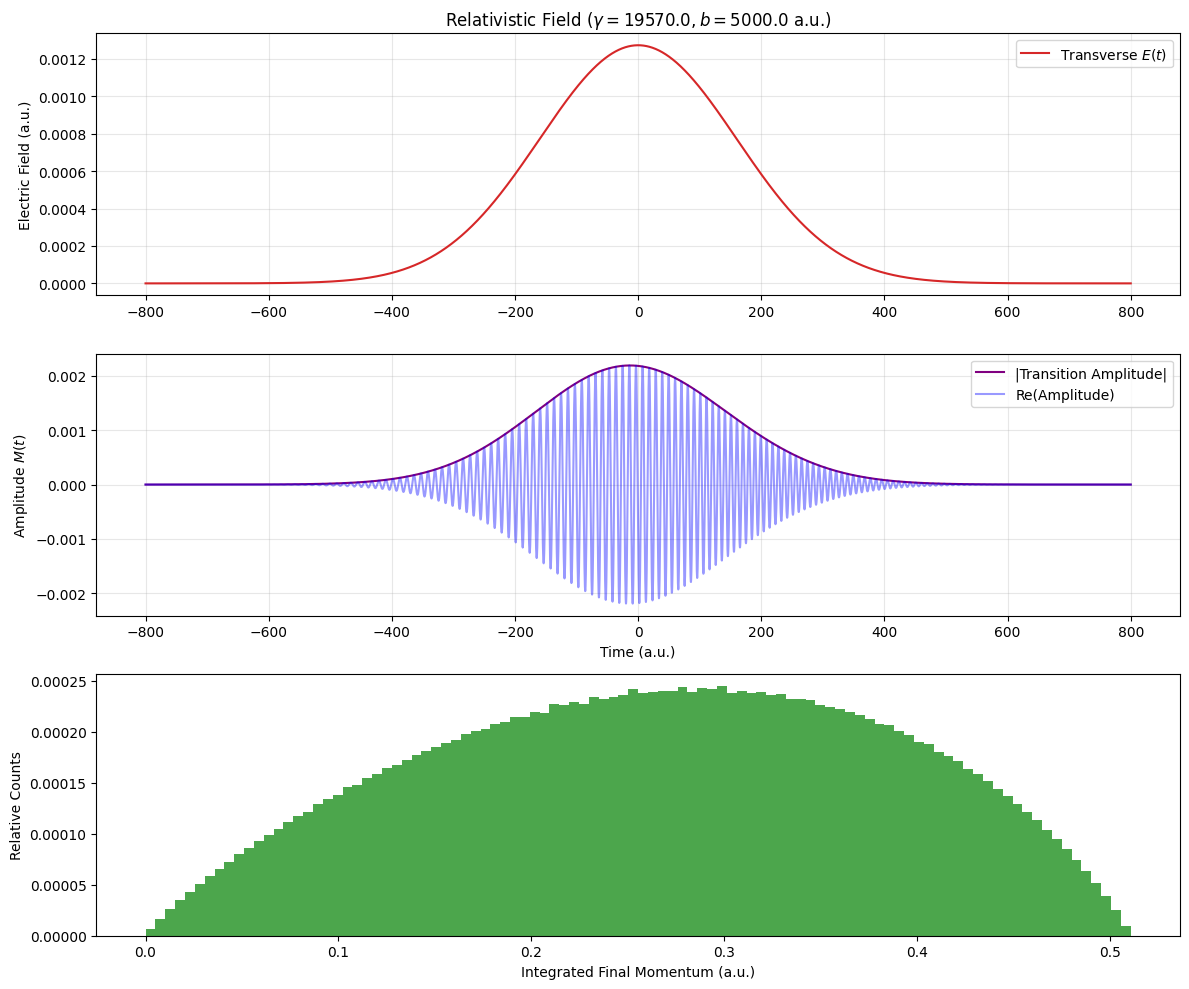

Final Integrated Amplitude: (3.217672033132974e-09-2.7447218652995373e-09j)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
def compute_relativistic_transition(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0):
    # --- 1. Constants in Atomic Units ---
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(10 * 80, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 20000)
    dt = t[1] - t[0]
    
    # --- 2. Charge Distribution q(t) ---
    # Gaussian normalized to Q_total
    q_t = Q_total * (1 / (np.sqrt(2 * np.pi) * sigma_au)) * np.exp(-t**2 / (2 * sigma_au**2))
    
    # --- 3. Point Charge Field Kernel E_R(t) ---
    # E_point = (gamma * b) / (b^2 + (gamma*v*t)^2)^(3/2)
    # (Pre-factor 1/4pi eps0 = 1 in a.u.)
    denominator = (b_au**2 + (gamma * v * t)**2)**(1.5)
    E_kernel = (gamma * b_au) / denominator

    # Plot E_kernel for verification
    # ax1.plot(t, E_kernel, color='tab:orange', label='Point Charge Field Kernel $E_{point}(t)$')
    # ax1.set_ylabel('Electric Field Kernel (a.u.)')
    # ax1.set_title('Point Charge Field Kernel $E_{point}(t)$')
    # ax1.legend()
    
    # --- 4. Numerical Integration (Convolution) to find E_total(t) ---
    # E_total(t) = integral q(t') * E_point(t - t') dt'
    E_total = np.convolve(q_t, E_kernel, mode='same') * dt * dt * dt
    
    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = -cumulative_trapezoid(E_total, t, initial=0)
    
    # Phase S(t) = integral [1/2 A(t')^2 + Ip] dt'
    integrand_S = 0.5 * (A_t**2) + Ip
    S_t = cumulative_trapezoid(integrand_S, t, initial=0)
    
    # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
    complex_integrand = np.exp(-1j * S_t) * E_total
    M_t = cumulative_trapezoid(complex_integrand, t, initial=0)

    # --- 7. Momentum Distribution: For each M_t slice compute the kick which is integration of E(t) from t to inf ---
    integrated_kick_t = -cumulative_trapezoid(E_total[::-1], t[::-1], initial=0)[::-1]
    
    
    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Amplitude Plot
    ax2.plot(t, np.abs(M_t), color='purple', label='|Transition Amplitude|')
    ax2.plot(t, M_t.real, color='blue', alpha=0.4, label='Re(Amplitude)')
    ax2.set_xlabel('Time (a.u.)')
    ax2.set_ylabel('Amplitude $M(t)$')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Kick Histogram
    ax3.hist(integrated_kick_t, bins=100, color='green', alpha=0.7, weights = np.abs(M_t)**2, label='Momentum Distribution')
    ax3.set_xlabel('Integrated Final Momentum (a.u.)')
    ax3.set_ylabel('Relative Counts')
    #ax1.plot(t, integrated_kick_t, color='orange', label='Integrated Kick')
    return t, M_t[-1]

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = compute_relativistic_transition(Ip_eV=15.0, sigma_au=160.0, Q_total=6e9, b_au=5000.0)
plt.tight_layout()
plt.show()
print(f"Final Integrated Amplitude: {final_val[1]}")

### 1. Scenarios
### 2. 10GeV 1 fs peak @ 10kA, 200pC total

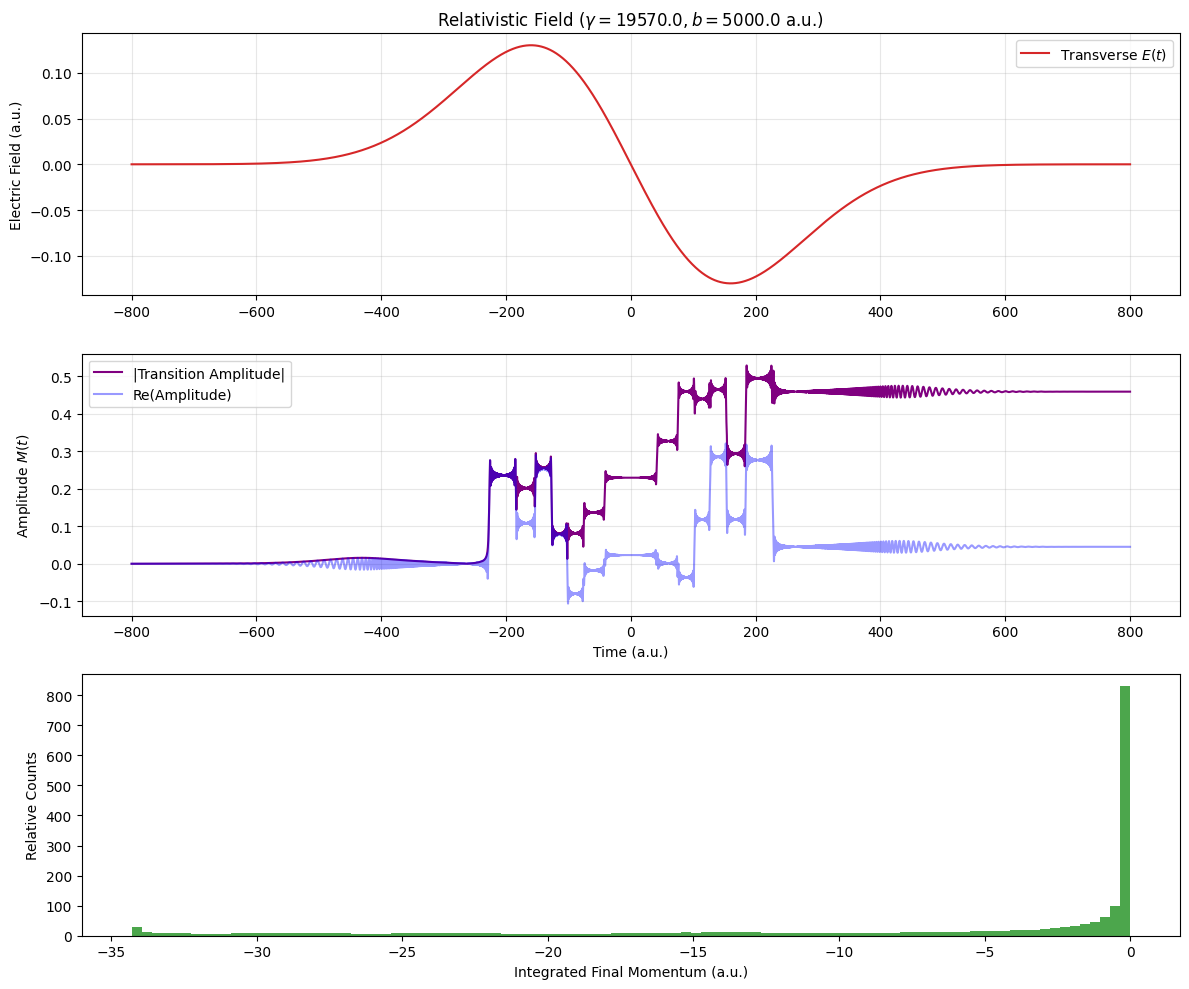

Final Integrated Amplitude: (0.04522928661412983+0.4571630590281978j)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
def compute_relativistic_transition_large_b(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0):
    # --- 1. Constants in Atomic Units ---
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(10 * 80, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 20000)
    dt = t[1] - t[0]
    
    # --- 2. Charge Distribution q(t) ---
    # Gaussian normalized to Q_total
    q_t = Q_total * (1 / (np.sqrt(2 * np.pi) * sigma_au)) * np.exp(-t**2 / (2 * sigma_au**2))
    
    # --- 3. Current I(t), differential of q(t) using scipy ---
    I_t = np.gradient(q_t, t, edge_order=2)
    
    # --- 4. Linear Approximation of E(t) for large b ---
    E_total = I_t * np.pi / 2 / b_au / v

    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = -cumulative_trapezoid(E_total, t, initial=0)
    
    # Phase S(t) = integral [1/2 A(t')^2 + Ip] dt'
    integrand_S = 0.5 * (A_t**2) + Ip
    S_t = cumulative_trapezoid(integrand_S, t, initial=0)
    
    # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
    complex_integrand = np.exp(-1j * S_t) * E_total
    M_t = cumulative_trapezoid(complex_integrand, t, initial=0)

    # --- 7. Momentum Distribution: For each M_t slice compute the kick which is integration of E(t) from t to inf ---
    integrated_kick_t = -cumulative_trapezoid(E_total[::-1], t[::-1], initial=0)[::-1]
    
    
    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Amplitude Plot
    ax2.plot(t, np.abs(M_t), color='purple', label='|Transition Amplitude|')
    ax2.plot(t, M_t.real, color='blue', alpha=0.4, label='Re(Amplitude)')
    ax2.set_xlabel('Time (a.u.)')
    ax2.set_ylabel('Amplitude $M(t)$')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Kick Histogram
    ax3.hist(integrated_kick_t, bins=100, color='green', alpha=0.7, weights = np.abs(M_t)**2, label='Momentum Distribution')
    ax3.set_xlabel('Integrated Final Momentum (a.u.)')
    ax3.set_ylabel('Relative Counts')
    #ax1.plot(t, integrated_kick_t, color='orange', label='Integrated Kick')
    return t, M_t[-1]

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = compute_relativistic_transition_large_b(Ip_eV=15.0, sigma_au=160.0, Q_total=6e9, b_au=5000.0)
plt.tight_layout()
plt.show()
print(f"Final Integrated Amplitude: {final_val[1]}")

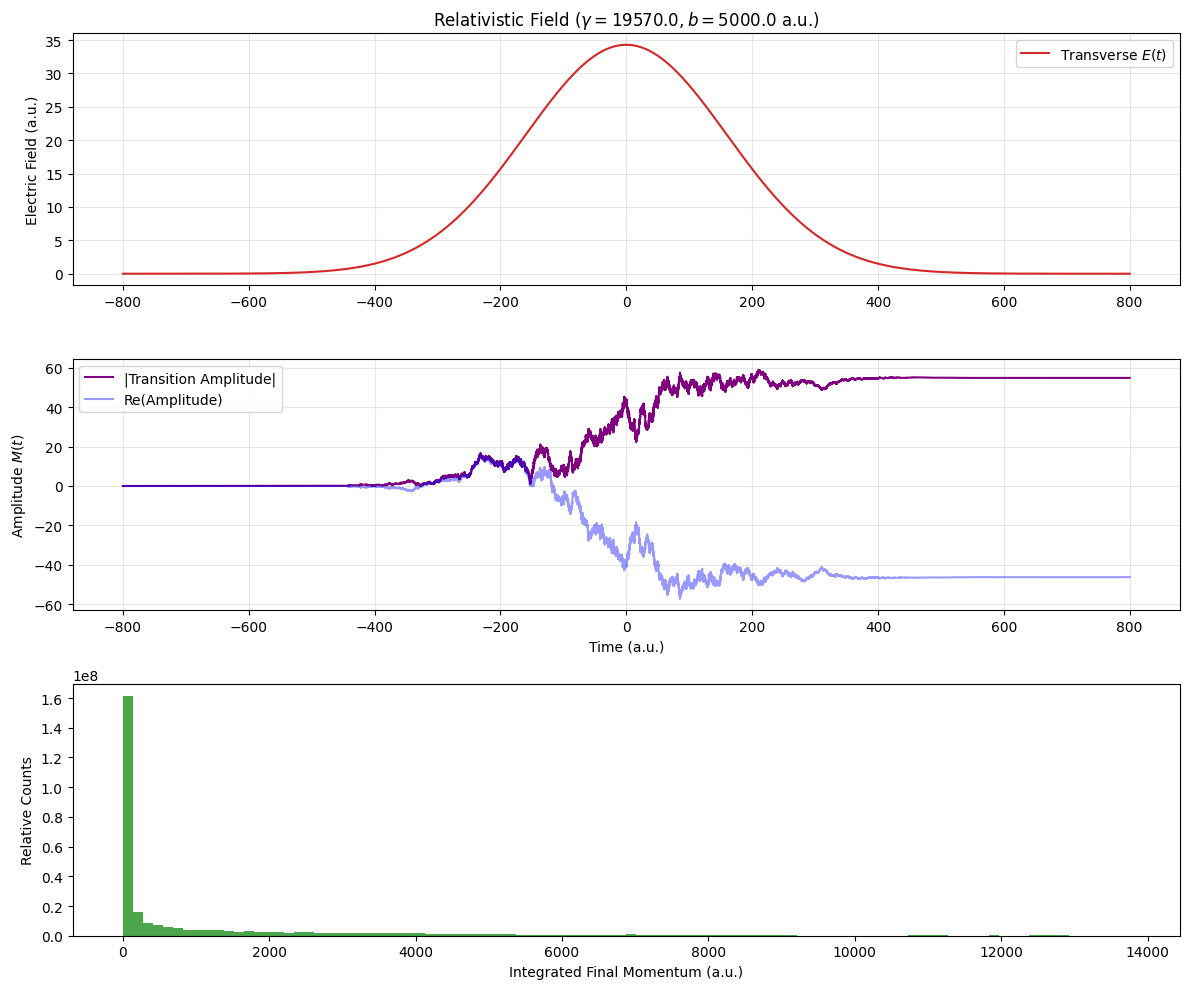

Final Integrated Amplitude: (-46.34800465464787-29.501282298591963j)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
def compute_relativistic_transition_large_b(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0):
    # --- 1. Constants in Atomic Units ---
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(10 * 80, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 200000)
    dt = t[1] - t[0]
    
    # --- 2. Current Profile I(t) ---
    # Gaussian normalized to Q_total
    I_t = Q_total * (1 / (np.sqrt(2 * np.pi) * sigma_au)) * np.exp(-t**2 / (2 * sigma_au**2))
    
    # --- 4. Linear Approximation of E(t) for large b ---
    E_total = I_t * np.pi / 2 / b_au / v

    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = -cumulative_trapezoid(E_total, t, initial=0)
    
    # Phase S(t) = integral [1/2 A(t')^2 + Ip] dt'
    integrand_S = 0.5 * (A_t**2) + Ip
    S_t = cumulative_trapezoid(integrand_S, t, initial=0)
    
    # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
    complex_integrand = np.exp(-1j * S_t) * E_total
    M_t = cumulative_trapezoid(complex_integrand, t, initial=0)

    # --- 7. Momentum Distribution: For each M_t slice compute the kick which is integration of E(t) from t to inf ---
    integrated_kick_t = -cumulative_trapezoid(E_total[::-1], t[::-1], initial=0)[::-1]
    
    
    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Amplitude Plot
    ax2.plot(t, np.abs(M_t), color='purple', label='|Transition Amplitude|')
    ax2.plot(t, M_t.real, color='blue', alpha=0.4, label='Re(Amplitude)')
    ax2.set_xlabel('Time (a.u.)')
    ax2.set_ylabel('Amplitude $M(t)$')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Kick Histogram
    ax3.hist(integrated_kick_t, bins=100, color='green', alpha=0.7, weights = np.abs(M_t)**2, label='Momentum Distribution')
    ax3.set_xlabel('Integrated Final Momentum (a.u.)')
    ax3.set_ylabel('Relative Counts')
    #ax1.plot(t, integrated_kick_t, color='orange', label='Integrated Kick')
    return t, M_t[-1]

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = compute_relativistic_transition_large_b(Ip_eV=15.0, sigma_au=160.0, Q_total=6e9, b_au=5000.0)
plt.tight_layout()
plt.show()
print(f"Final Integrated Amplitude: {final_val[1]}")

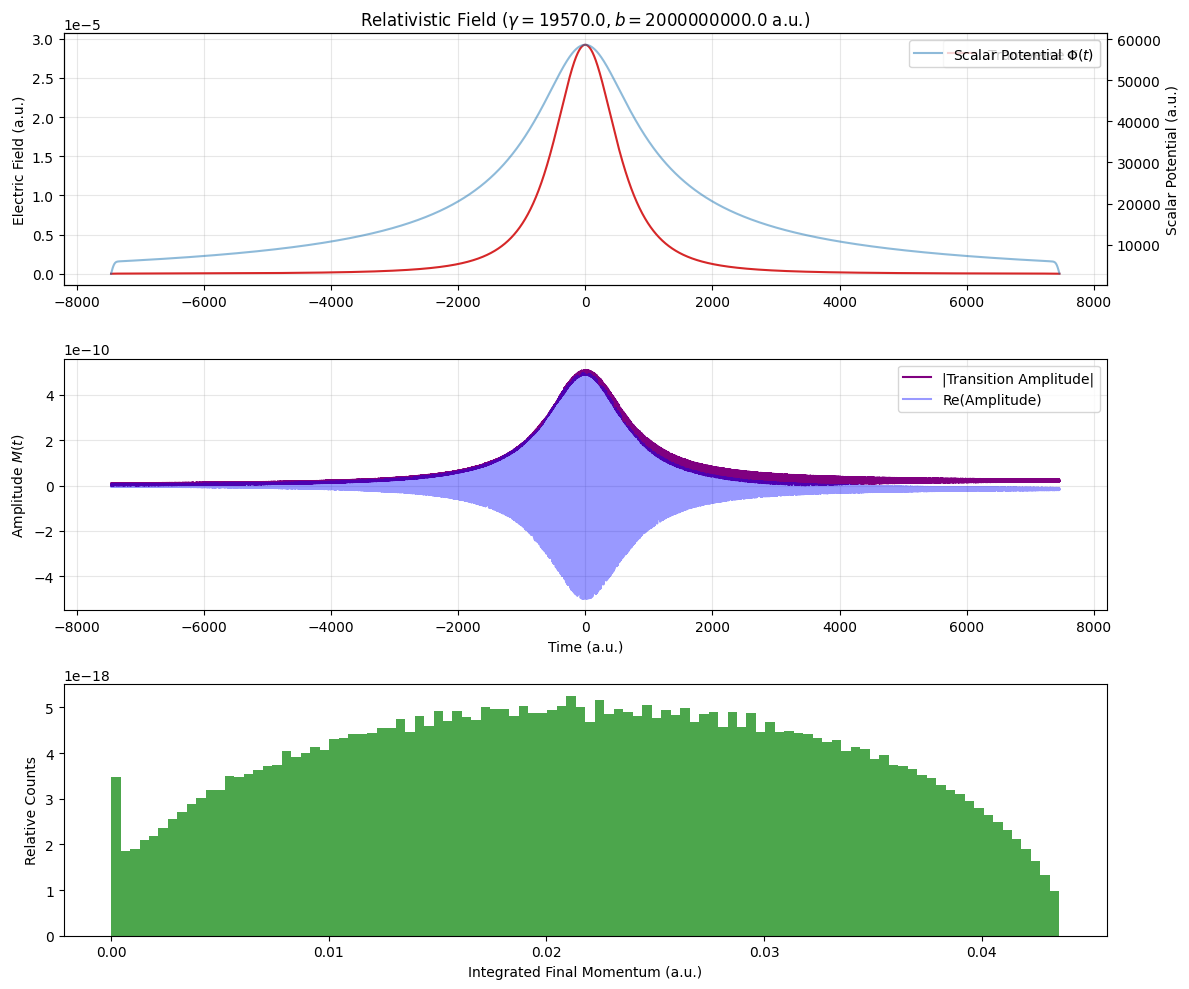

Final Integrated Amplitude: (-1.7773267234508847e-11-1.0951585111753386e-11j)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
def compute_relativistic_transition_large_b(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0, p_target = 0.0):
    # --- 1. Constants in Atomic Units ---
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(10 * 80, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 20000)
    dt = t[1] - t[0]
    
    # --- 2. Charge Distribution q(t) ---
    # Gaussian normalized to Q_total
    q_t = Q_total * (1 / (np.sqrt(2 * np.pi) * sigma_au)) * np.exp(-t**2 / (2 * sigma_au**2))
    
    # --- 3. Point Charge Field Kernel E_R(t) ---
    # E_point = (gamma * b) / (b^2 + (gamma*v*t)^2)^(3/2)
    # (Pre-factor 1/4pi eps0 = 1 in a.u.)
    denominator = (b_au**2 + (gamma * v * t)**2)**(1.5)
    E_kernel = (gamma * b_au) / denominator

    # Plot E_kernel for verification
    # ax1.plot(t, E_kernel, color='tab:orange', label='Point Charge Field Kernel $E_{point}(t)$')
    # ax1.set_ylabel('Electric Field Kernel (a.u.)')
    # ax1.set_title('Point Charge Field Kernel $E_{point}(t)$')
    # ax1.legend()
    
    # --- 4. Numerical Integration (Convolution) to find E_total(t) ---
    # E_total(t) = integral q(t') * E_point(t - t') dt'
    E_total = np.convolve(q_t, E_kernel, mode='same') * dt
    Phi_total = np.convolve(q_t, (1 / np.sqrt((v * t)**2 + (b_au/gamma)**2)), mode='same') * dt

    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = -cumulative_trapezoid(E_total, t, initial=0)
    
    # Phase S(t) = integral [1/2 A(t')^2 + Ip] dt'
    integrand_S = 0.5 * (A_t**2) + Ip - Phi_total + p_target ** 2 / 2
    S_t = cumulative_trapezoid(integrand_S, t, initial=0)
    
    # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
    M_t = oscillatory_cumulative_integral(t, E_total, S_t)

    # --- 7. Momentum Distribution: For each M_t slice compute the kick which is integration of E(t) from t to inf ---
    integrated_kick_t = -cumulative_trapezoid(E_total[::-1], t[::-1], initial=0)[::-1]
    
    
    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1a = ax1.twinx()
    ax1a.plot(t, Phi_total, color='tab:blue', label='Scalar Potential $\Phi(t)$', alpha=0.5)
    ax1a.set_ylabel('Scalar Potential (a.u.)')
    ax1a.legend(loc='upper right')
    
    # Amplitude Plot
    ax2.plot(t, np.abs(M_t), color='purple', label='|Transition Amplitude|')
    ax2.plot(t, M_t.real, color='blue', alpha=0.4, label='Re(Amplitude)')
    ax2.set_xlabel('Time (a.u.)')
    ax2.set_ylabel('Amplitude $M(t)$')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Kick Histogram
    ax3.hist(integrated_kick_t, bins=100, color='green', alpha=0.7, weights = np.abs(M_t)**2, label='Momentum Distribution')
    ax3.set_xlabel('Integrated Final Momentum (a.u.)')
    ax3.set_ylabel('Relative Counts')
    #ax1.plot(t, integrated_kick_t, color='orange', label='Integrated Kick')
    return t, M_t[-1]

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = compute_relativistic_transition_large_b(Ip_eV=15.0, sigma_au=40.0, Q_total=6e9, b_au=2.0e9, p_target = 0.0)
plt.tight_layout()
plt.show()
print(f"Final Integrated Amplitude: {final_val[1]}")

Total Charge (C): 9.61e-10, Primary Charge (C): 9.51e-10, Secondary Charge (C): 1.06e-11


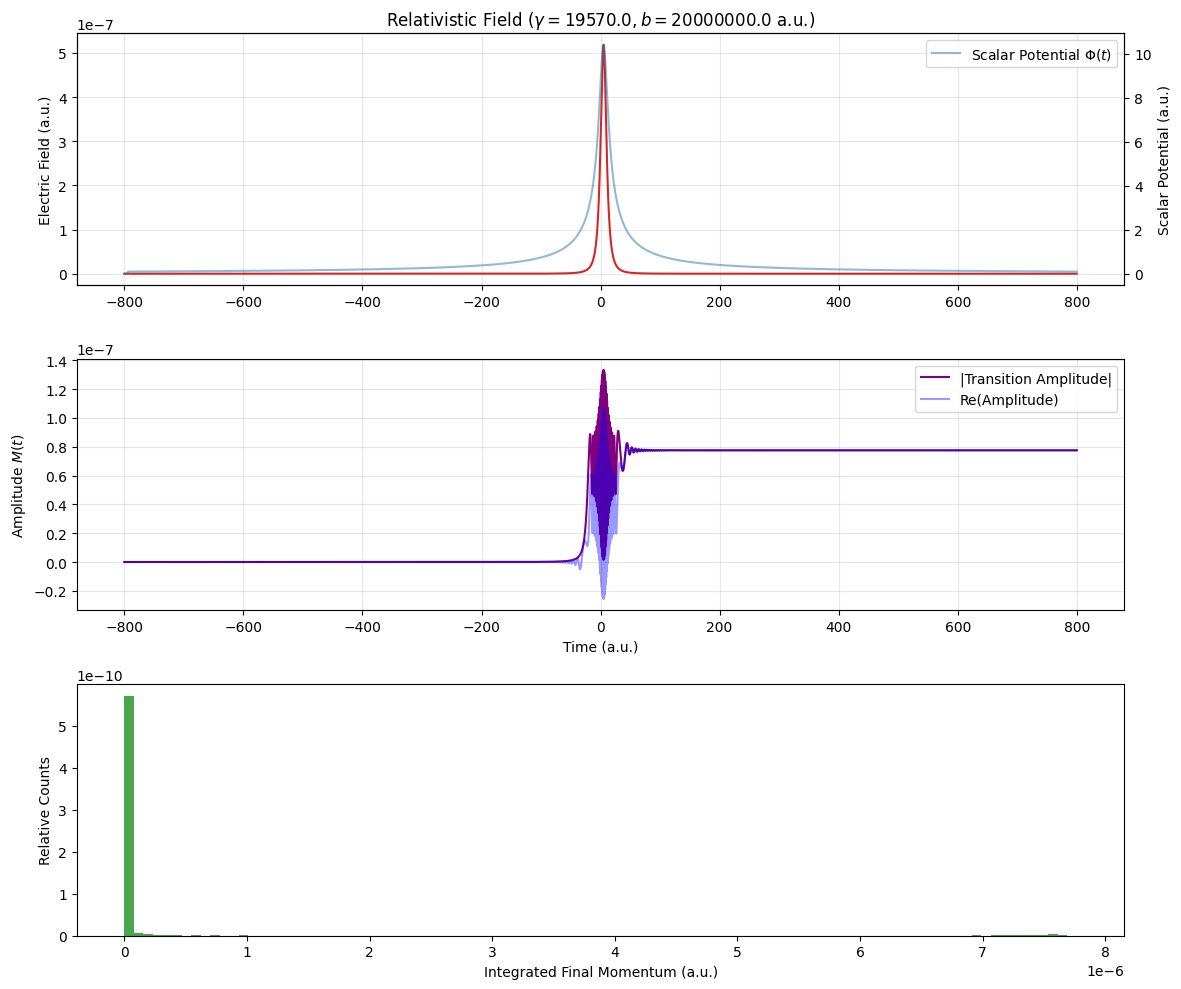

Final Integrated Amplitude: (7.753102869517367e-08+2.1975289586157884e-09j)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))
def compute_relativistic_transition_large_b(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0):
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(10 * 80, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 200000)
    dt = t[1] - t[0]
    
    # --- 2. Charge Distribution q(t) ---
    # Gaussian normalized to Q_total
    q_t = laser_heater_current_profile(t, spike_delay_fs=5.0)
    
    # --- 3. Point Charge Field Kernel E_R(t) ---
    # E_point = (gamma * b) / (b^2 + (gamma*v*t)^2)^(3/2)
    # (Pre-factor 1/4pi eps0 = 1 in a.u.)
    denominator = (b_au**2 + (gamma * v * t)**2)**(1.5)
    E_kernel = (gamma * b_au) / denominator

    # Plot E_kernel for verification
    # ax1.plot(t, E_kernel, color='tab:orange', label='Point Charge Field Kernel $E_{point}(t)$')
    # ax1.set_ylabel('Electric Field Kernel (a.u.)')
    # ax1.set_title('Point Charge Field Kernel $E_{point}(t)$')
    # ax1.legend()
    
    # --- 4. Numerical Integration (Convolution) to find E_total(t) ---
    # E_total(t) = integral q(t') * E_point(t - t') dt'
    E_total = np.convolve(q_t, E_kernel, mode='same') * dt
    Phi_total = np.convolve(q_t, (1 / np.sqrt((v * t)**2 + (b_au/gamma)**2)), mode='same') * dt

    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = -cumulative_trapezoid(E_total, t, initial=0)

    Phi_max = np.max(Phi_total)
    
    momentum_range = np.linspace(0, np.sqrt(2 * Phi_max), 20)
    amplitude_results = []
    for p_target in momentum_range:
        # Phase S(t) = integral [1/2 A(t')^2 + Ip] dt'
        integrand_S = 0.5 * (A_t**2) + Ip - Phi_total + p_target ** 2 / 2
        S_t = cumulative_trapezoid(integrand_S, t, initial=0)
        
        # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
        M_t = oscillatory_cumulative_integral(t, E_total, S_t)
        # Take amplitude at final time
        M_f = M_t[-1]
        amplitude_results.append(M_f)
    
    
    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.grid(True, alpha=0.3)
    ax1a = ax1.twinx()
    ax1a.plot(t, Phi_total, color='tab:blue', label='Scalar Potential $\Phi(t)$', alpha=0.5)
    ax1a.set_ylabel('Scalar Potential (a.u.)')
    ax1a.legend(loc='upper right')
    
    # Amplitude Plot
    ax2.plot(momentum_range, np.abs(amplitude_results), color='purple', label='|Transition Amplitude| vs Momentum')
    ax2.set_xlabel('Target Momentum (a.u.)')
    ax2.set_ylabel('Amplitude $M(p)$')
    ax2.legend()
    ax2.grid(True, alpha=0.3)


    return t, amplitude_results

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = compute_relativistic_transition_large_b(Ip_eV=15.0, sigma_au=40.0, Q_total=6e9, b_au=2.0e7)
plt.tight_layout()
plt.show()
print(f"Final Integrated Amplitude: {final_val[1]}")

### The Coulomb Gauge

Total Charge (C): 9.61e-10, Primary Charge (C): 8.66e-10, Secondary Charge (C): 9.58e-11


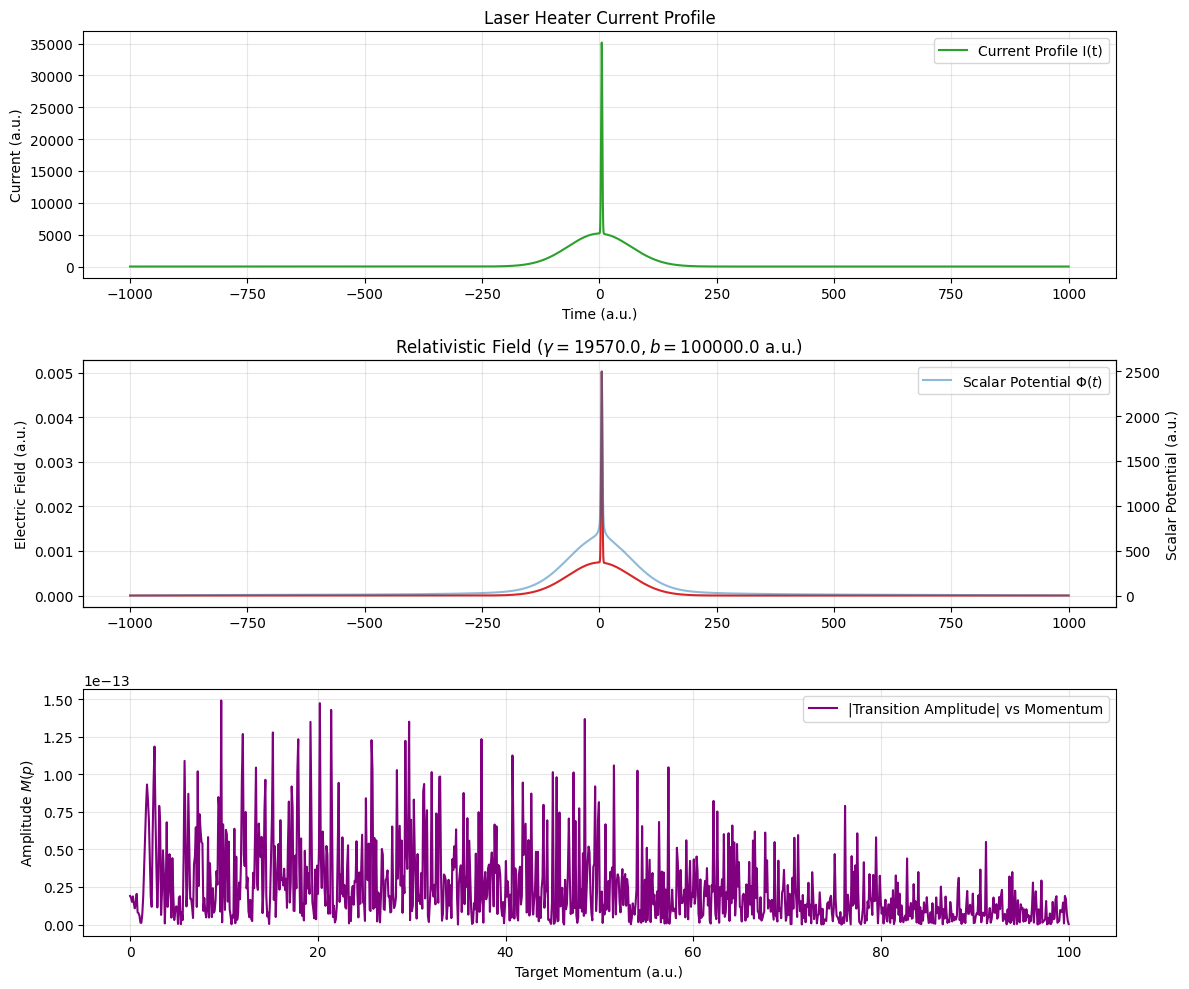

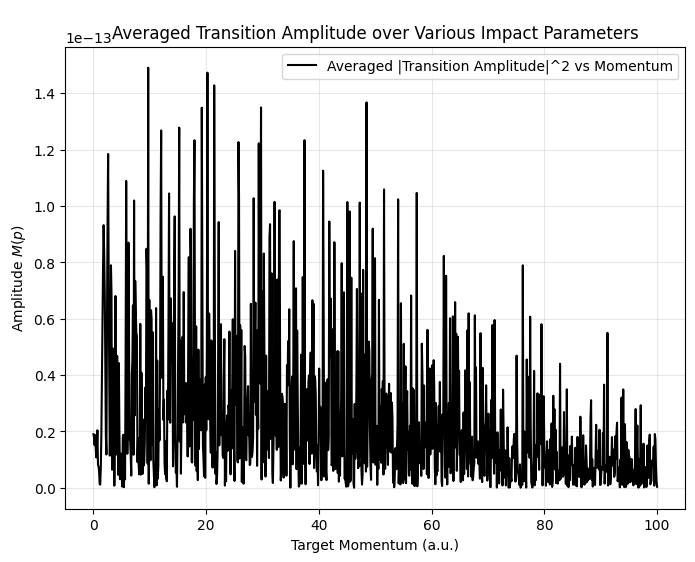

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 10))
def compute_relativistic_transition_large_b(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0, momentum_range = None):
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(1000, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 50000)
    dt = t[1] - t[0]
    
    # --- 2. Charge Distribution q(t) ---
    # Gaussian normalized to Q_total
    q_t = laser_heater_current_profile(t, spike_delay_fs=5.0, spike_peak_A=30000, spike_fwhm_fs=3, primary_length_um=20)
    
    # --- 3. Point Charge Field Kernel E_R(t) ---
    # E_point = (gamma * b) / (b^2 + (gamma*v*t)^2)^(3/2)
    # (Pre-factor 1/4pi eps0 = 1 in a.u.)
    denominator = (b_au**2 + (gamma * v * t)**2)**(1.5)
    E_kernel = (gamma * b_au) / denominator

    # Plot E_kernel for verification
    # ax1.plot(t, E_kernel, color='tab:orange', label='Point Charge Field Kernel $E_{point}(t)$')
    # ax1.set_ylabel('Electric Field Kernel (a.u.)')
    # ax1.set_title('Point Charge Field Kernel $E_{point}(t)$')
    # ax1.legend()
    
    # --- 4. Numerical Integration (Convolution) to find E_total(t) ---
    # E_total(t) = integral q(t') * E_point(t - t') dt'
    E_total = np.convolve(q_t, E_kernel, mode='same') * dt
    Phi_total = np.convolve(q_t, (1 / np.sqrt((v * t)**2 + (b_au/gamma)**2)), mode='same') * dt

    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = -cumulative_trapezoid(E_total, t, initial=0)

    Phi_max = np.max(Phi_total)
    if momentum_range is None:
        momentum_range = np.linspace(0, 2*np.sqrt(Phi_max), 1000)
    amplitude_sq_results = []
    for p_target in momentum_range:
        # Phase S(t) = integral [1/2 A(t')^2 + Ip] dt'
        integrand_S = 0.5 * (A_t**2) + Ip + Phi_total + p_target ** 2 / 2
        S_t = cumulative_trapezoid(-integrand_S, t, initial=0)
        
        # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
        M_t = oscillatory_cumulative_integral(t, E_total, S_t)
        # Take amplitude at final time
        M_f = M_t[-1]
        amplitude_sq_results.append(M_f**2)
    
    # Current plot

    ax0.plot(t, q_t, color='tab:green', label='Current Profile I(t)')
    ax0.set_ylabel('Current (a.u.)')
    ax0.set_xlabel('Time (a.u.)')
    ax0.set_title('Laser Heater Current Profile')
    ax0.legend()
    ax0.grid(True, alpha=0.3)

    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.grid(True, alpha=0.3)
    ax1a = ax1.twinx()
    ax1a.plot(t, Phi_total, color='tab:blue', label='Scalar Potential $\Phi(t)$', alpha=0.5)
    ax1a.set_ylabel('Scalar Potential (a.u.)')
    ax1a.legend(loc='upper right')
    
    # Amplitude Plot
    ax2.plot(momentum_range, np.abs(amplitude_sq_results), color='purple', label='|Transition Amplitude| vs Momentum')
    ax2.set_xlabel('Target Momentum (a.u.)')
    ax2.set_ylabel('Amplitude $M(p)$')
    ax2.grid(True, alpha=0.3)


    return t, amplitude_sq_results

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = []
momentum_range = np.linspace(0, 100, 1000)
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=1.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=2.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=3.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=4.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=5.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=1.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=2.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=3.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=4.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=5.5e5, momentum_range=momentum_range))
ax2.legend()
plt.tight_layout()
plt.show()

# Plot averaged results over b_au values
plt.figure(figsize=(8,6))

amplitude_matrix = np.array([np.abs(res[1]) for res in final_val])
average_amplitude = np.mean(amplitude_matrix, axis=0)
plt.plot(momentum_range, average_amplitude, color='black', label='Averaged |Transition Amplitude|^2 vs Momentum')
plt.xlabel('Target Momentum (a.u.)')
plt.ylabel('Amplitude $M(p)$')
plt.title('Averaged Transition Amplitude over Various Impact Parameters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### The Weyl Gauge (No Electrostatic Potential)

Total Charge (C): 9.61e-10, Primary Charge (C): 8.97e-10, Secondary Charge (C): 6.39e-11


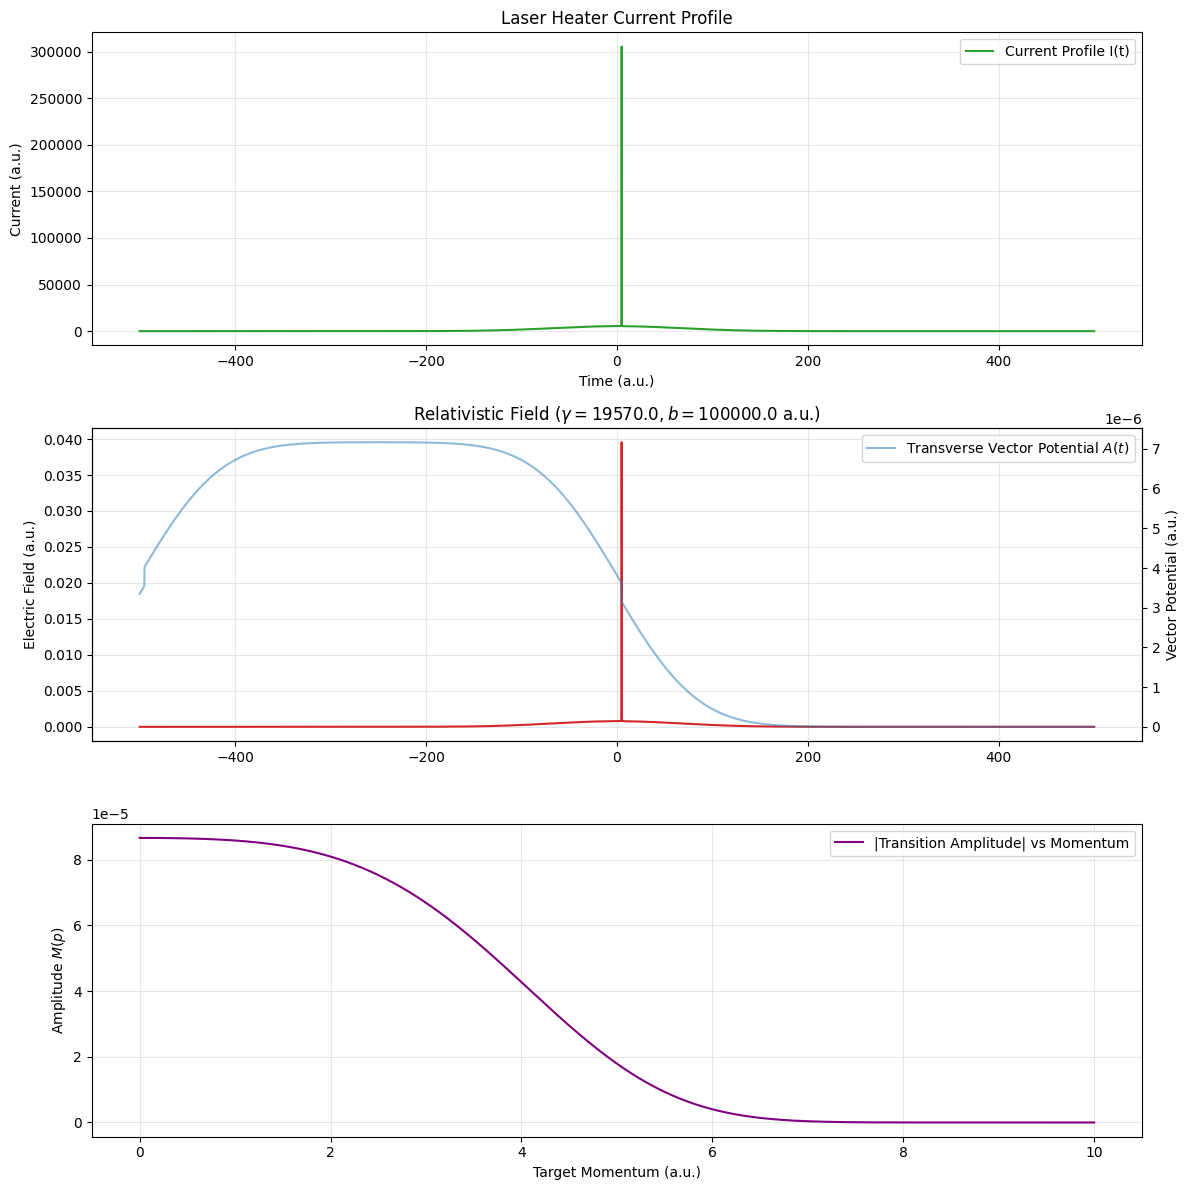

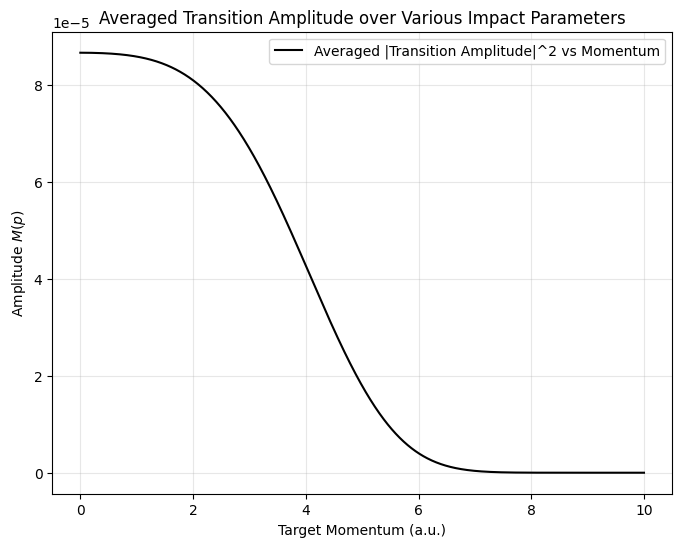

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12))
def compute_relativistic_transition_large_b(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0, momentum_range = None):
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(500, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 500000)
    dt = t[1] - t[0]
    
    # --- 2. Charge Distribution q(t) ---
    # Gaussian normalized to Q_total
    q_t = laser_heater_current_profile(t, spike_delay_fs=5.0, spike_peak_A=300000, spike_fwhm_fs=0.2, primary_length_um=20)
    
    # --- 3. Point Charge Field Kernel E_R(t) ---
    # E_point = (gamma * b) / (b^2 + (gamma*v*t)^2)^(3/2)
    # (Pre-factor 1/4pi eps0 = 1 in a.u.)
    denominator = (b_au**2 + (gamma * v * t)**2)**(1.5)
    E_kernel = (gamma * b_au) / denominator
    R = np.sqrt(b_au**2 + (gamma * (v * t))**2)
    A_transverse_kernel = 1/gamma/v*b_au/R/(gamma * v * t + R)
    # Plot E_kernel for verification
    # ax1.plot(t, E_kernel, color='tab:orange', label='Point Charge Field Kernel $E_{point}(t)$')
    # ax1.set_ylabel('Electric Field Kernel (a.u.)')
    # ax1.set_title('Point Charge Field Kernel $E_{point}(t)$')
    # ax1.legend()
    
    # --- 4. Numerical Integration (Convolution) to find E_total(t) ---
    # E_total(t) = integral q(t') * E_point(t - t') dt'
    E_total = np.convolve(q_t, E_kernel, mode='same') * dt

    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = np.convolve(q_t, A_transverse_kernel, mode='same') * dt

    Phi_max = np.max(A_t ** 2 / 2)
    if momentum_range is None:
        momentum_range = np.linspace(0, 2*np.sqrt(Phi_max), 1000)
    amplitude_sq_results = []
    for p_target in momentum_range:
        # Phase S(t) = integral [1/2 A(t')^2 + Ip + pA(t')+p^2] dt'
        integrand_S = 0.5 * (A_t**2) + Ip + p_target ** 2 / 2 + A_t * p_target
        S_t = cumulative_trapezoid(-integrand_S, t, initial=0)
        
        # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
        M_t = oscillatory_cumulative_integral(t, E_total, S_t)
        # Take amplitude at final time
        M_f = M_t[-1]
        amplitude_sq_results.append(M_f**2)
    
    # Current plot

    ax0.plot(t, q_t, color='tab:green', label='Current Profile I(t)')
    ax0.set_ylabel('Current (a.u.)')
    ax0.set_xlabel('Time (a.u.)')
    ax0.set_title('Laser Heater Current Profile')
    ax0.legend()
    ax0.grid(True, alpha=0.3)

    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.grid(True, alpha=0.3)
    ax1a = ax1.twinx()
    ax1a.plot(t, A_t, color='tab:blue', label='Transverse Vector Potential $A(t)$', alpha=0.5)
    ax1a.set_ylabel('Vector Potential (a.u.)')
    ax1a.legend(loc='upper right')

    # Volkov phase plot
    
    # Amplitude Plot
    ax2.plot(momentum_range, np.abs(amplitude_sq_results), color='purple', label='|Transition Amplitude| vs Momentum')
    ax2.set_xlabel('Target Momentum (a.u.)')
    ax2.set_ylabel('Amplitude $M(p)$')
    ax2.grid(True, alpha=0.3)


    return t, amplitude_sq_results

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = []
momentum_range = np.linspace(0, 10, 1000)
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=1.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=2.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=3.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=4.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=5.0e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=1.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=2.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=3.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=4.5e5, momentum_range=momentum_range))
#final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=5.5e5, momentum_range=momentum_range))
ax2.legend()
plt.tight_layout()
plt.show()

# Plot averaged results over b_au values
plt.figure(figsize=(8,6))

amplitude_matrix = np.array([np.abs(res[1]) for res in final_val])
average_amplitude = np.mean(amplitude_matrix, axis=0)
plt.plot(momentum_range, average_amplitude, color='black', label='Averaged |Transition Amplitude|^2 vs Momentum')
plt.xlabel('Target Momentum (a.u.)')
plt.ylabel('Amplitude $M(p)$')
plt.title('Averaged Transition Amplitude over Various Impact Parameters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Weyl Gauge Simplified Convolution

Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10
Total Charge (C): 9.61e-10, Primary Charge (C): 7.48e-10, Secondary Charge (C): 2.13e-10


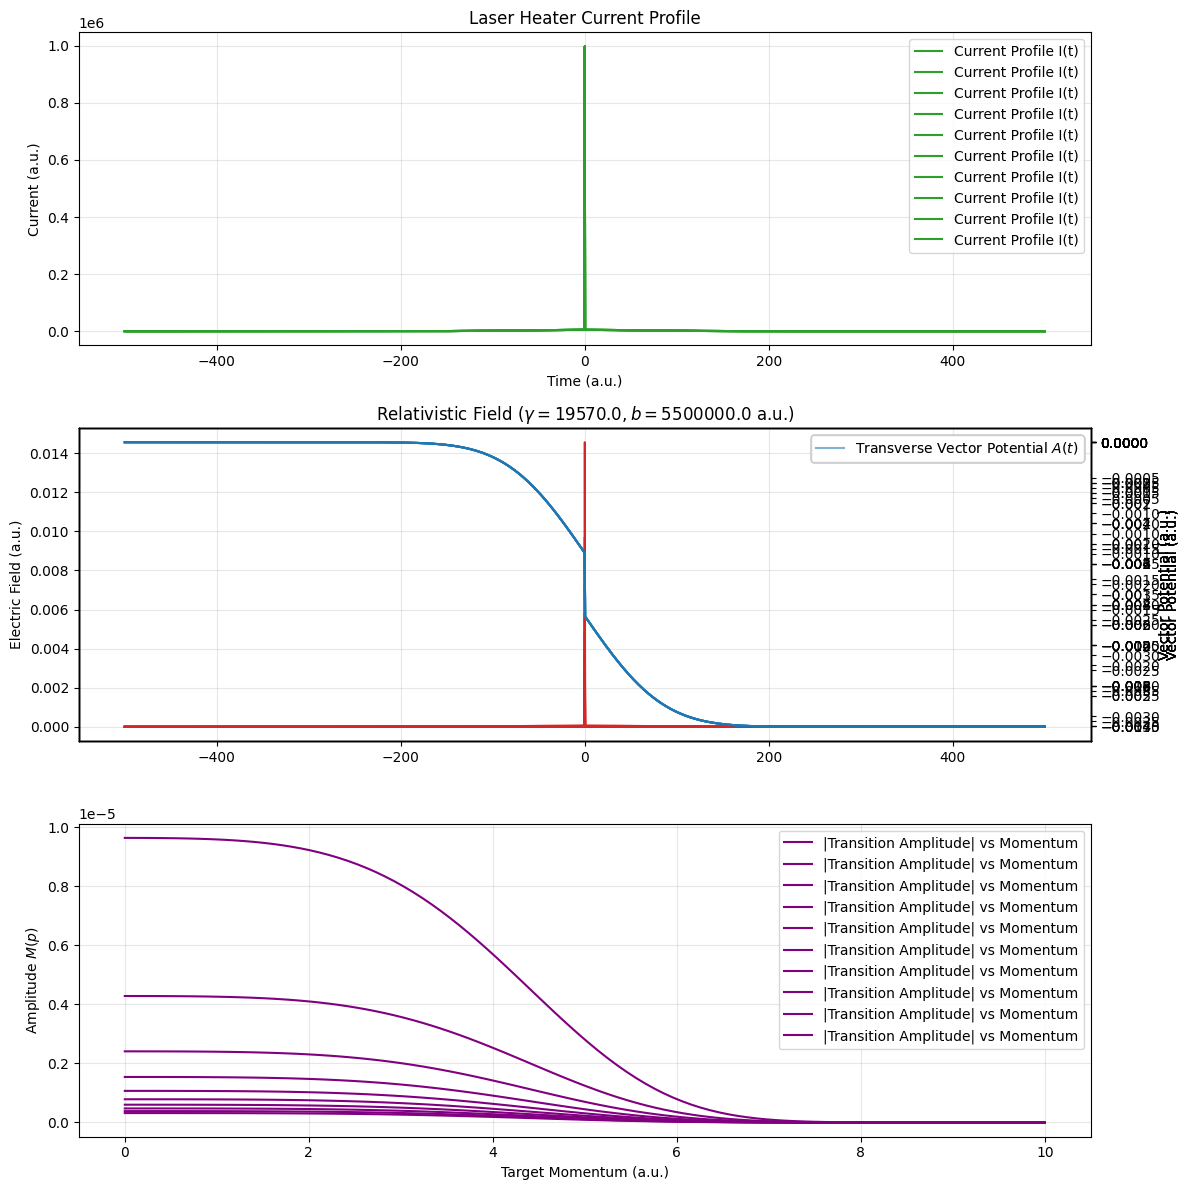

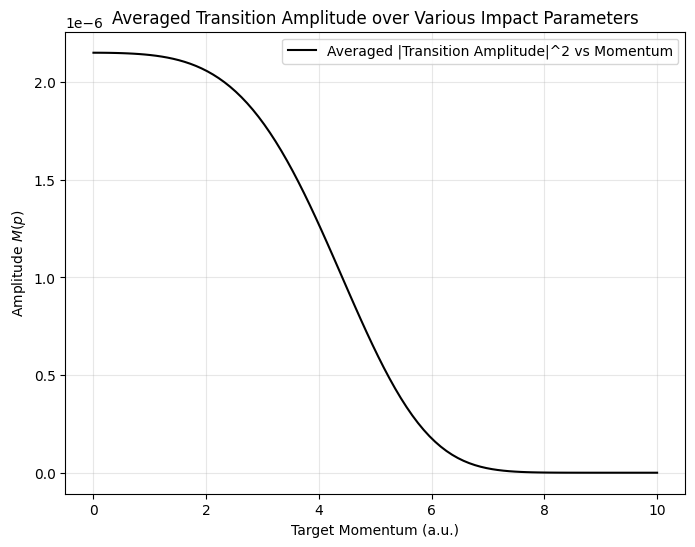

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.constants import physical_constants

# --- Plotting ---
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 12))
def compute_relativistic_transition_large_b(Ip_eV, sigma_au, Q_total=1e6, gamma = 19570, b_au=10.0, momentum_range = None):
    c_au = 137.036
    v = c_au
    Ip = Ip_eV / 27.21138
    
    # Time grid (sufficiently fine to resolve the relativistic contraction)
    # The peak width is roughly b/(gamma*v), so we scale the grid accordingly
    peak_width = b_au / (gamma * v)
    t_limit = max(500, 10 * peak_width)
    t = np.linspace(-t_limit, t_limit, 50000)
    dt = t[1] - t[0]
    
    # --- 2. Charge Distribution q(t) ---
    # Gaussian normalized to Q_total
    I_t = laser_heater_current_profile(t, spike_delay_fs=0, spike_peak_A=1000000, spike_fwhm_fs=0.2, primary_length_um=20)
    
    # --- 3. Point Charge Field Kernel E_R(t) ---
    # E_point = (gamma * b) / (b^2 + (gamma*v*t)^2)^(3/2)
    # (Pre-factor 1/4pi eps0 = 1 in a.u.)
    denominator = (b_au**2 + (gamma * v * t)**2)**(1.5)
    E_kernel = (gamma * b_au) / denominator
    R = np.sqrt(b_au**2 + (gamma * (v * t))**2)
    A_transverse_kernel = 1/gamma/v*b_au/R/(gamma * v * t + R)
    # Plot E_kernel for verification
    # ax1.plot(t, E_kernel, color='tab:orange', label='Point Charge Field Kernel $E_{point}(t)$')
    # ax1.set_ylabel('Electric Field Kernel (a.u.)')
    # ax1.set_title('Point Charge Field Kernel $E_{point}(t)$')
    # ax1.legend()
    
    # --- 4. Numerical Integration (Convolution) to find E_total(t) ---
    # E_total(t) = integral q(t') * E_point(t - t') dt'
    E_total = I_t * 2 / b_au / v

    # --- 5. Vector Potential A(t) and Phase S(t) ---
    # E = -dA/dt => A(t) = - integral_{-inf}^t E(t') dt'
    A_t = -cumulative_trapezoid(E_total, t, initial=0)

    Phi_max = np.max(A_t ** 2 / 2)
    if momentum_range is None:
        momentum_range = np.linspace(0, 2*np.sqrt(Phi_max), 1000)
    amplitude_sq_results = []
    for p_target in momentum_range:
        # Phase S(t) = integral [1/2 A(t')^2 + Ip + pA(t')+p^2] dt'
        integrand_S = 0.5 * (A_t**2) + Ip + p_target ** 2 / 2 + A_t * p_target
        S_t = cumulative_trapezoid(-integrand_S, t, initial=0)
        
        # --- 6. Final Product: Integral e^{-iS(t)} E(t) dt ---
        M_t = oscillatory_cumulative_integral(t, E_total, S_t)
        # Take amplitude at final time
        M_f = M_t[-1]
        amplitude_sq_results.append(np.abs(M_f)**2)
    
    # Current plot

    ax0.plot(t, I_t, color='tab:green', label='Current Profile I(t)')
    ax0.set_ylabel('Current (a.u.)')
    ax0.set_xlabel('Time (a.u.)')
    ax0.set_title('Laser Heater Current Profile')
    ax0.legend()
    ax0.grid(True, alpha=0.3)

    # Field Plot
    ax1.plot(t, E_total, color='tab:red', label='Transverse $E(t)$')
    ax1.set_ylabel('Electric Field (a.u.)')
    ax1.set_title(f'Relativistic Field ($\gamma = {gamma:.1f}, b = {b_au:.1f}$ a.u.)')
    ax1.grid(True, alpha=0.3)
    ax1a = ax1.twinx()
    ax1a.plot(t, A_t, color='tab:blue', label='Transverse Vector Potential $A(t)$', alpha=0.5)
    ax1a.set_ylabel('Vector Potential (a.u.)')
    ax1a.legend(loc='upper right')

    # Volkov phase plot
    
    # Amplitude Plot
    ax2.plot(momentum_range, np.abs(amplitude_sq_results), color='purple', label='|Transition Amplitude| vs Momentum')
    ax2.set_xlabel('Target Momentum (a.u.)')
    ax2.set_ylabel('Amplitude $M(p)$')
    ax2.grid(True, alpha=0.3)


    return t, amplitude_sq_results

# Execution
# Time in atomic units, 1 a.u. = 24 as
# b_au chosen to be 5000 a.u. , 1 a.u. = 0.0529 nm
# gamma corresponding to 10 GeV electron is about 19588
final_val = []
momentum_range = np.linspace(0, 10, 100)
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=1.0e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=2.0e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=3.0e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=4.0e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=5.0e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=1.5e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=2.5e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=3.5e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=4.5e6, momentum_range=momentum_range))
final_val.append(compute_relativistic_transition_large_b(Ip_eV=13.6, sigma_au=40.0, Q_total=6e9, b_au=5.5e6, momentum_range=momentum_range))
ax2.legend()
plt.tight_layout()
plt.show()

# Plot averaged results over b_au values
plt.figure(figsize=(8,6))

amplitude_matrix = np.array([np.abs(res[1]) for res in final_val])
average_amplitude = np.mean(amplitude_matrix, axis=0)
plt.plot(momentum_range, average_amplitude, color='black', label='Averaged |Transition Amplitude|^2 vs Momentum')
plt.xlabel('Target Momentum (a.u.)')
plt.ylabel('Amplitude $M(p)$')
plt.title('Averaged Transition Amplitude over Various Impact Parameters')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [1]:
import numpy as np

def calculate_final_ke(q_nC, b_um, v_c=0.99):
    # --- Constants and Conversions ---
    # 1 nC to atomic units of charge (1 e = 1.602e-19 C)
    q_au = q_nC * 1e-9 / 1.602176634e-19
    
    # 1 um to atomic units of length (1 a0 = 5.29177e-11 m)
    b_au = b_um * 1e-6 / 5.291772109e-11
    
    # Speed of light in a.u.
    c_au = 137.036
    v = v_c * c_au
    
    # --- Momentum Transfer (Impulse) ---
    # Delta P = integral of E dt = 2q / (v * b) in a.u.
    p_final = (2 * q_au) / (v * b_au)
    
    # --- Kinetic Energy ---
    # K = p^2 / 2m (m=1 in a.u.)
    ke_au = (p_final**2) / 2
    
    # Convert back to eV (1 Hartree = 27.2114 eV)
    ke_eV = ke_au * 27.21138
    
    return ke_eV, p_final, q_au

# Inputs
q_input = 1.0  # nC
b_input = 1.0  # um

ke, p, q_converted = calculate_final_ke(q_input, b_input)

print(f"Total Charge (a.u.): {q_converted:.2e}")
print(f"Final Momentum (a.u.): {p:.4f}")
print(f"Final Kinetic Energy: {ke:.4f} eV")

Total Charge (a.u.): 6.24e+09
Final Momentum (a.u.): 4869.1244
Final Kinetic Energy: 322568760.5094 eV
